In [14]:
import TimeSliceImport
import numpy as np
import keras
import random
import gc
from keras.models import Sequential

from keras.layers import (Dense, Dropout, Activation, Conv1D,Concatenate, Flatten)
from keras.layers import (MaxPooling1D,BatchNormalization,LocallyConnected1D, GlobalAveragePooling1D,LeakyReLU,PReLU)
from keras.activations import (tanh,softmax)
from keras.optimizers import SGD
from sklearn import (metrics,preprocessing)
import RamanPlotTools as pt
import matplotlib.pyplot as plt
from matplotlib.image import NonUniformImage
from mpl_toolkits import mplot3d
from keras.optimizers import Adam

In [2]:
from keras.backend import tensorflow_backend as backend
from keras import backend as K
print(backend.device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11945152568008488932
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7594190439
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1666030136959756588
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
path="/home/waseda/Desktop/shared/SKYP_KYP_SYP"
numClasses=4
types=["PS", "yeast","spore","kleb"]
spectra=TimeSliceImport.importData(path,types)
classes=list(map(lambda x:TimeSliceImport.RamanSample.mappings[x],types))
sortedTypesTuples=sorted(zip(types,classes),key=lambda x:x[1])
sortedTypes=[x[0] for x in sortedTypesTuples]

startPNT=201


def makeRandomData(filter="NONE",start=startPNT,end=1600,points=1000,removeBG=False):
    trainingSamples, validationSamples = TimeSliceImport.splitData(spectra, 0.25)
    trainingSpectraList = list(map(lambda x: x.interpolatedSpectra(start, end, points, filter=filter,removeBackground=removeBG), trainingSamples))
    validationSpectraList = list(map(lambda x: x.interpolatedSpectra(start, end, points,filter=filter,removeBackground=removeBG), validationSamples))
    trainingData,trainingClasses,validationData,validationClasses = TimeSliceImport.makeSVMInputData(trainingSpectraList,
                                                                                                     validationSpectraList)

    oneHotTrainingClasses=keras.utils.to_categorical(trainingClasses,num_classes=numClasses)
    oneHotValidationClasses=keras.utils.to_categorical(validationClasses,num_classes=numClasses)
    return trainingData, oneHotTrainingClasses, validationData, oneHotValidationClasses

trainingData, oneHotTrainingClasses, validationData, oneHotValidationClasses=makeRandomData()


def scalarClassesFromOneHotArray(oneHotArray):
    return np.argmax(oneHotArray,axis=1)

def plotResult(truth,result, score, normalize=False):
    pt.plotResult(scalarClassesFromOneHotArray(result),scalarClassesFromOneHotArray(truth),sortedTypes)
    mtrx = metrics.confusion_matrix(scalarClassesFromOneHotArray(truth),scalarClassesFromOneHotArray(result))
    pt.plotConfusionMatrix(mtrx,sortedTypes,"Classification Result (%.03g )" % score, normalize=normalize)

def plotLearning(history):
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Training Accuracy', 'Cross-Validation Accuracy'])
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Training Loss', 'Cross-Validation Loss'])
    plt.show()

Liu, J. et al., 2017. Deep convolutional neural networks for Raman spectrum recognition: a unified solution. The Analyst, 142(21), pp.4067–4074.

In [6]:
def makeModelCNN(batchNormalize=False,points=100,local=(0,0,0),kernelSize=(21,11,5)):
    model = Sequential()
    if local[0] == 0:
        model.add(Conv1D(16,kernelSize[0], input_shape=(points, 1)))
    else:
        model.add(LocallyConnected1D(16,kernelSize[0], input_shape=(points, 1)))  
    
    if batchNormalize is True:
        model.add(BatchNormalization())
        
    model.add(LeakyReLU())
    model.add(MaxPooling1D(2,2))
    
    if local[1] == 0:
        model.add(Conv1D(32,kernelSize[1]))
    else:
        model.add(LocallyConnected1D(32,kernelSize[1]))
        
    if batchNormalize is True:
        model.add(BatchNormalization())
        
    model.add(LeakyReLU())
    model.add(MaxPooling1D(2,2))
    
    if local[2] == 0:
        model.add(Conv1D(64,kernelSize[2]))
    else:
        model.add(LocallyConnected1D(64,kernelSize[2]))
        
    if batchNormalize is True:
        model.add(BatchNormalization())
        
    model.add(LeakyReLU())
    model.add(MaxPooling1D(2,2))
    
    model.add(Flatten())
    model.add(Dense(2048))
    if batchNormalize is True:
        model.add(BatchNormalization())
        
    model.add(Activation("tanh"))
    # model.add(MaxPooling1D(2))
    model.add(Dropout(0.5))
   
    model.add(Dense(numClasses))
    if batchNormalize is True:
        model.add(BatchNormalization())
    model.add(Activation("softmax"))
        
    model.compile(loss="categorical_crossentropy",
                  optimizer='adam',
                  metrics=['accuracy'])
    return model


In [11]:
def runModelCNN(numRepetitions=1):
    scores=[]
    labels=[]
   
    
    for normalize in [False,True]:
        for local in [(1,1,1),(1,0,0),(0,0,0)]:
            runScores=[]
            results=[]
            truths=[]
            labels.append("{},{}".format(str(normalize),str(local)))
            
            for i in range(numRepetitions):
                
                rangeEnd=2500
                dist=rangeEnd-startPNT
            
                trainingData, oneHotTrainingClasses, validationData, oneHotValidationClasses=makeRandomData(start=startPNT,
                                                                                                        end=rangeEnd,
                                                                                                        points=dist)
                
                reshapedTraining = np.expand_dims(trainingData, axis=2)
                reshapedValidation = np.expand_dims(validationData, axis=2)
            
                
                model=makeModelCNN(points=reshapedTraining.shape[1],batchNormalize=normalize,local=local)
                if i==0:
                    print(model.summary())
        
                history = model.fit(reshapedTraining, oneHotTrainingClasses, epochs=100, validation_split=0.05, verbose=0)
                score = model.evaluate(reshapedValidation, oneHotValidationClasses)
                prd = model.predict(reshapedValidation)
                
                skScore=metrics.accuracy_score(scalarClassesFromOneHotArray(oneHotValidationClasses),scalarClassesFromOneHotArray(prd))
                print("Score: {}, SKScore: {}".format(score[1], skScore))
                print(skScore)
                results.extend(scalarClassesFromOneHotArray(prd))
                runScores.append(skScore)
                truths.extend(scalarClassesFromOneHotArray(oneHotValidationClasses))
                plt.plot(history.history['acc'], color='blue')
                plt.plot(history.history['val_acc'], color='orange')
                K.clear_session()
                del history
                del model
                gc.collect()
            
            avgScore=sum(runScores)/float(len(runScores))
            print("Score: {}".format(avgScore))
            plt.title('model accuracy')
            plt.ylabel('accuracy')
            plt.xlabel('epoch')
            plt.legend(['Training Accuracy', 'Cross-Validation Accuracy'])
            plt.show()
            scores.append(runScores)
            pt.plotResult(results,truths,sortedTypes)
            mtrx = metrics.confusion_matrix(truths,results)
            pt.plotConfusionMatrix(mtrx,sortedTypes,"Classification Result (%.03g )" % avgScore, normalize=True)
    
    npScores=np.array(scores)
    
    return labels,npScores

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected1d_1 (Local (None, 2279, 16)          802208    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 2279, 16)          0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 1139, 16)          0         
_________________________________________________________________
locally_connected1d_2 (Local (None, 1129, 32)          6394656   
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 1129, 32)          0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 564, 32)           0         
_________________________________________________________________
locally_connected1d_3 (Local (None, 560, 64)           5770240   
__________

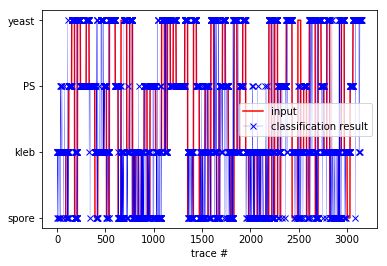

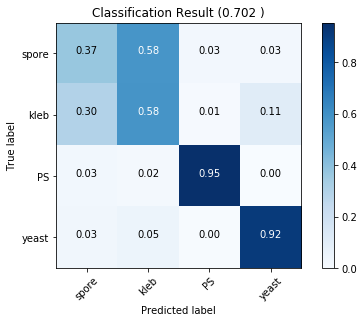

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected1d_1 (Local (None, 2279, 16)          802208    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2279, 16)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1139, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1129, 32)          5664      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1129, 32)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 564, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 560, 64)           10304     
__________

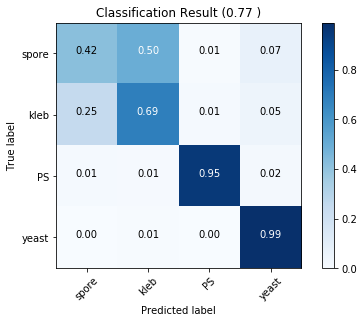

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2279, 16)          352       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2279, 16)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1139, 16)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1129, 32)          5664      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1129, 32)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 564, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 560, 64)           10304     
__________

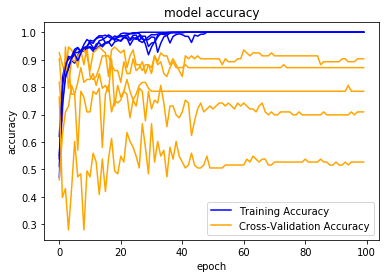

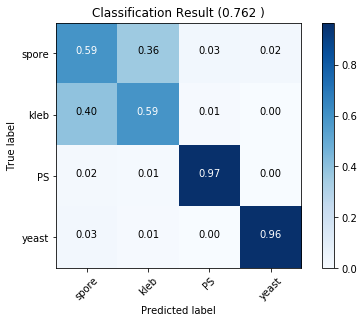

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected1d_1 (Local (None, 2279, 16)          802208    
_________________________________________________________________
batch_normalization_1 (Batch (None, 2279, 16)          64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2279, 16)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1139, 16)          0         
_________________________________________________________________
locally_connected1d_2 (Local (None, 1129, 32)          6394656   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1129, 32)          128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1129, 32)          0         
__________

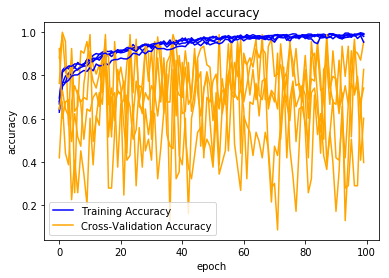

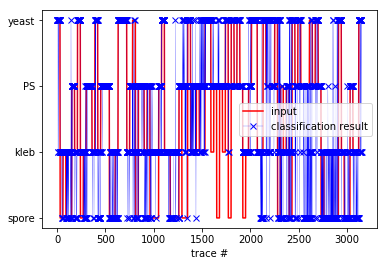

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected1d_1 (Local (None, 2279, 16)          802208    
_________________________________________________________________
batch_normalization_1 (Batch (None, 2279, 16)          64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2279, 16)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1139, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1129, 32)          5664      
_________________________________________________________________
batch_normalization_2 (Batch (None, 1129, 32)          128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1129, 32)          0         
__________

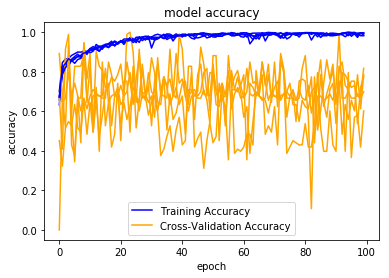

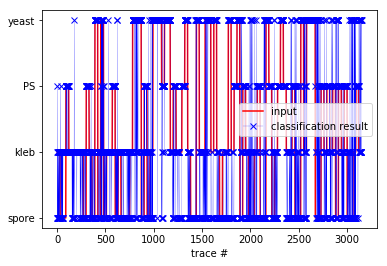

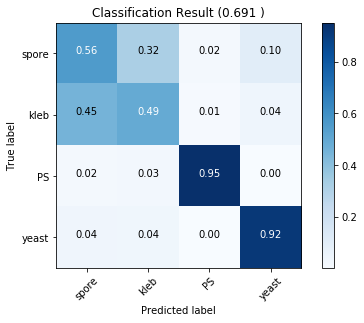

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2279, 16)          352       
_________________________________________________________________
batch_normalization_1 (Batch (None, 2279, 16)          64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2279, 16)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1139, 16)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1129, 32)          5664      
_________________________________________________________________
batch_normalization_2 (Batch (None, 1129, 32)          128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1129, 32)          0         
__________

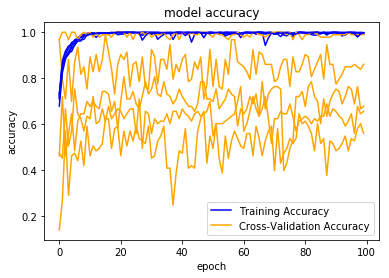

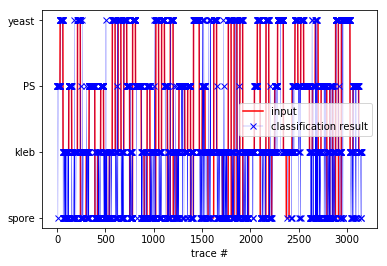

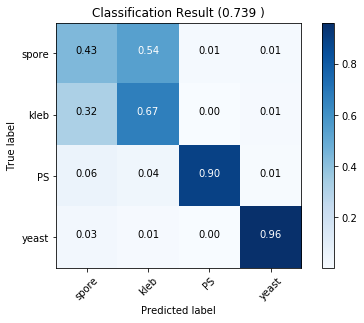

{'whiskers': [<matplotlib.lines.Line2D at 0x7f90ea873c18>,
 'caps': [<matplotlib.lines.Line2D at 0x7f90ea89f2e8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f90ea873ac8>,
 'medians': [<matplotlib.lines.Line2D at 0x7f90ea89f978>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f90ea89ffd0>,
 'means': [<matplotlib.lines.Line2D at 0x7f90ea89fcc0>,
  <matplotlib.lines.Line2D at 0x7f90c44c4278>]}

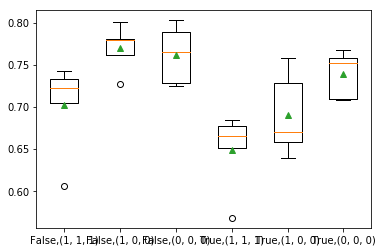

In [12]:
labels,scores=runModelCNN(5)
plt.boxplot(np.transpose(scores), labels=labels, showmeans=True)

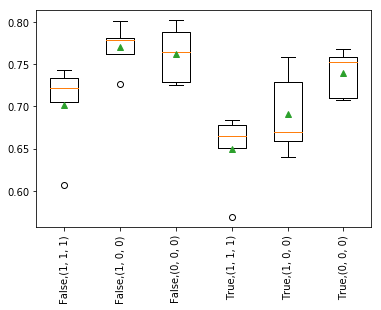

In [13]:
plt.boxplot(np.transpose(scores), labels=labels, showmeans=True)
plt.xticks(rotation=90)
plt.show()

In [15]:
def makeModelCNN(batchNormalize=False,points=100,relu=(1,1,1),kernelSize=(21,11,5)):
    model = Sequential()
    model.add(Conv1D(16,kernelSize[0], input_shape=(points, 1)))

    if batchNormalize is True:
        model.add(BatchNormalization())
        
    if relu[0] == 1:  
        model.add(LeakyReLU())
    elif relu[0] == 0:
        model.add(Activation("relu"))
    elif relu[0] == 2:
        model.add(PReLU())
        
    model.add(MaxPooling1D(2,2))
    
    
    model.add(Conv1D(32,kernelSize[1]))
    
    
        
    if batchNormalize is True:
        model.add(BatchNormalization())
        
    if relu[0] == 1:  
        model.add(LeakyReLU())
    elif relu[0] == 0:
        model.add(Activation("relu"))
    elif relu[0] == 2:
        model.add(PReLU())
        
    model.add(MaxPooling1D(2,2))
    
    
    model.add(Conv1D(64,kernelSize[2]))
     
    if batchNormalize is True:
        model.add(BatchNormalization())
        
    if relu[0] == 1:  
        model.add(LeakyReLU())
    elif relu[0] == 0:
        model.add(Activation("relu"))
    elif relu[0] == 2:
        model.add(PReLU())
        
    model.add(MaxPooling1D(2,2))
    
    model.add(Flatten())
    model.add(Dense(2048))
    if batchNormalize is True:
        model.add(BatchNormalization())
        
    model.add(Activation("tanh"))
    # model.add(MaxPooling1D(2))
    model.add(Dropout(0.5))
   
    model.add(Dense(numClasses))
    if batchNormalize is True:
        model.add(BatchNormalization())
    model.add(Activation("softmax"))
        
    model.compile(loss="categorical_crossentropy",
                  optimizer='adam',
                  metrics=['accuracy'])
    return model


In [19]:
def runModelCNN(numRepetitions=1):
    scores=[]
    labels=[]
   
    
    for normalize in [False,True]:
        for relu in [(1,1,1),(0,0,0),(2,2,2)]:
            runScores=[]
            results=[]
            truths=[]
            labels.append("{},{}".format(str(normalize),str(relu)))
            
            for i in range(numRepetitions):
                
                rangeEnd=2500
                dist=rangeEnd-startPNT
            
                trainingData, oneHotTrainingClasses, validationData, oneHotValidationClasses=makeRandomData(start=startPNT,
                                                                                                        end=rangeEnd,
                                                                                                        points=dist)
                
                reshapedTraining = np.expand_dims(trainingData, axis=2)
                reshapedValidation = np.expand_dims(validationData, axis=2)
            
                
                model=makeModelCNN(points=reshapedTraining.shape[1],batchNormalize=normalize,relu=relu)
                if i==0:
                    print(model.summary())
        
                history = model.fit(reshapedTraining, oneHotTrainingClasses, epochs=100, validation_split=0.05, verbose=0)
                score = model.evaluate(reshapedValidation, oneHotValidationClasses)
                prd = model.predict(reshapedValidation)
                
                skScore=metrics.accuracy_score(scalarClassesFromOneHotArray(oneHotValidationClasses),scalarClassesFromOneHotArray(prd))
                print("Score: {}, SKScore: {}".format(score[1], skScore))
                print(skScore)
                results.extend(scalarClassesFromOneHotArray(prd))
                runScores.append(skScore)
                truths.extend(scalarClassesFromOneHotArray(oneHotValidationClasses))
                plt.plot(history.history['acc'], color='blue')
                plt.plot(history.history['val_acc'], color='orange')
                K.clear_session()
                del history
                del model
                gc.collect()
            
            avgScore=sum(runScores)/float(len(runScores))
            print("Score: {}".format(avgScore))
            plt.title('model accuracy')
            plt.ylabel('accuracy')
            plt.xlabel('epoch')
            plt.legend(['Training Accuracy', 'Cross-Validation Accuracy'])
            plt.show()
            scores.append(runScores)
            pt.plotResult(results,truths,sortedTypes)
            mtrx = metrics.confusion_matrix(truths,results)
            pt.plotConfusionMatrix(mtrx,sortedTypes,"Classification Result (%.03g )" % avgScore, normalize=True)
    
    npScores=np.array(scores)
    
    return labels,npScores

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2279, 16)          352       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2279, 16)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1139, 16)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1129, 32)          5664      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1129, 32)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 564, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 560, 64)           10304     
__________

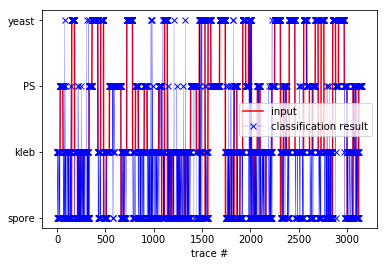

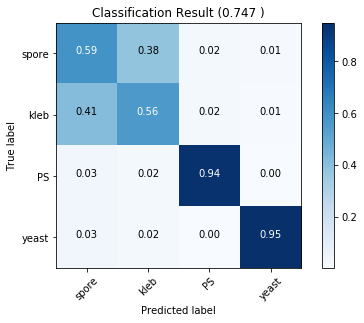

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2279, 16)          352       
_________________________________________________________________
activation_1 (Activation)    (None, 2279, 16)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1139, 16)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1129, 32)          5664      
_________________________________________________________________
activation_2 (Activation)    (None, 1129, 32)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 564, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 560, 64)           10304     
__________

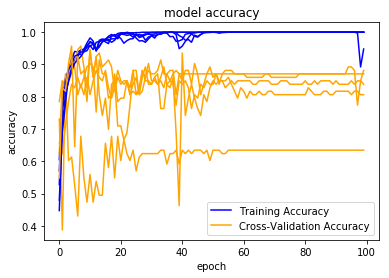

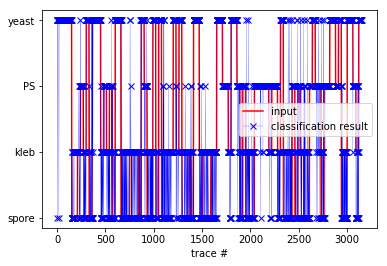

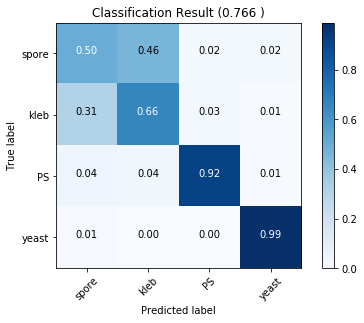

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2279, 16)          352       
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 2279, 16)          36464     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1139, 16)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1129, 32)          5664      
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 1129, 32)          36128     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 564, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 560, 64)           10304     
__________

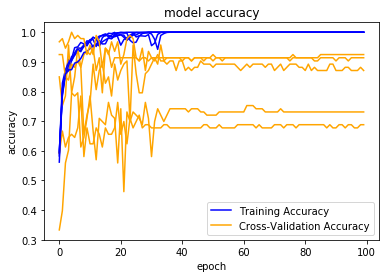

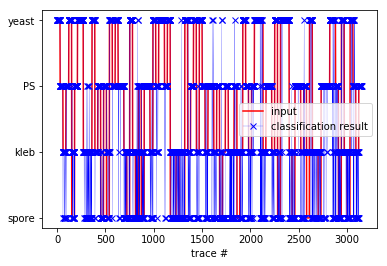

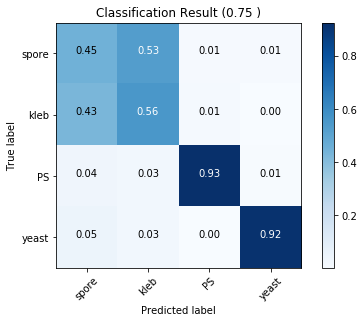

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2279, 16)          352       
_________________________________________________________________
batch_normalization_1 (Batch (None, 2279, 16)          64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2279, 16)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1139, 16)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1129, 32)          5664      
_________________________________________________________________
batch_normalization_2 (Batch (None, 1129, 32)          128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1129, 32)          0         
__________

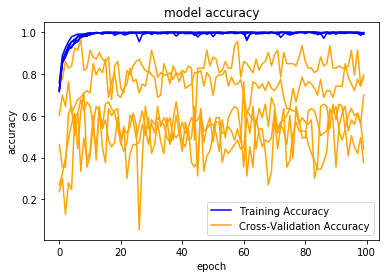

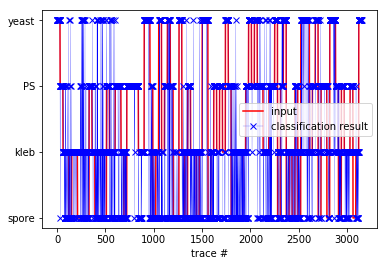

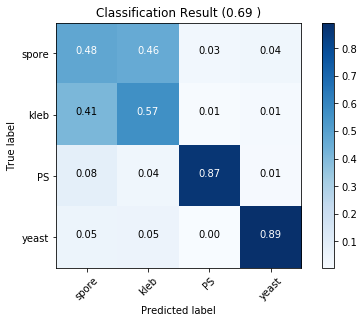

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2279, 16)          352       
_________________________________________________________________
batch_normalization_1 (Batch (None, 2279, 16)          64        
_________________________________________________________________
activation_1 (Activation)    (None, 2279, 16)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1139, 16)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1129, 32)          5664      
_________________________________________________________________
batch_normalization_2 (Batch (None, 1129, 32)          128       
_________________________________________________________________
activation_2 (Activation)    (None, 1129, 32)          0         
__________

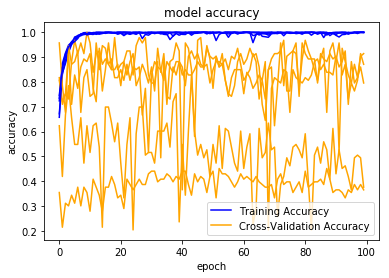

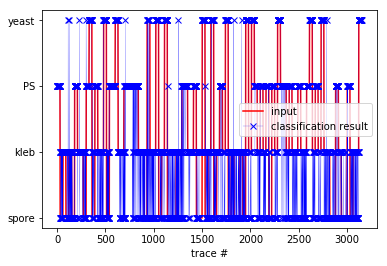

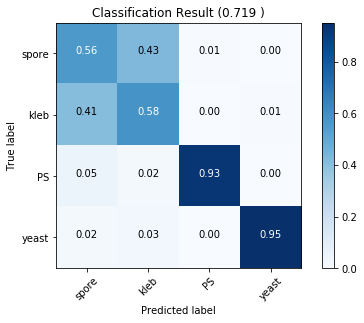

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2279, 16)          352       
_________________________________________________________________
batch_normalization_1 (Batch (None, 2279, 16)          64        
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 2279, 16)          36464     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1139, 16)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1129, 32)          5664      
_________________________________________________________________
batch_normalization_2 (Batch (None, 1129, 32)          128       
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 1129, 32)          36128     
__________

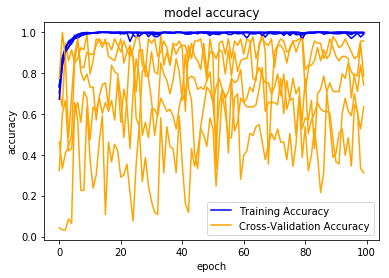

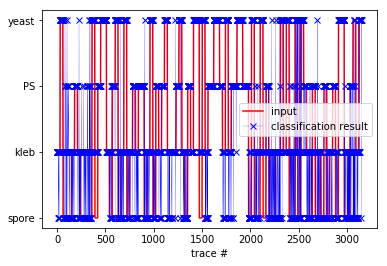

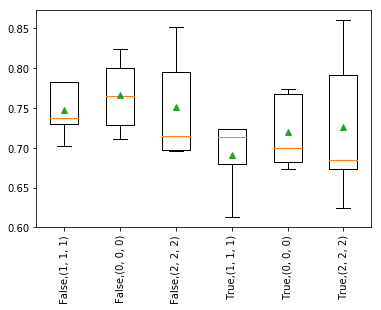

In [20]:
labels,scores=runModelCNN(5)
plt.boxplot(np.transpose(scores), labels=labels, showmeans=True)
plt.xticks(rotation=90)
plt.show()

In [ ]:
def data(index,start=startPNT,end=1600,points=1000,filter="NONE"):
    
    validationSample=spectra[index]
    validationSamples=[validationSample]
    
    trainingSamples=spectra.copy()
    trainingSamples.pop(index)
    # print(list(map(lambda x:x.name,trainingSamples)))
    trainingSpectraList = list(map(lambda x: x.interpolatedSpectra(start, end, points, filter=filter,removeBackground=False), trainingSamples))
    validationSpectraList = list(map(lambda x: x.interpolatedSpectra(start, end, points,filter=filter,removeBackground=False), validationSamples))
    trainingData,trainingClasses,validationData,validationClasses = TimeSliceImport.makeSVMInputData(trainingSpectraList,
                                                                                                     validationSpectraList)
    oneHotTrainingClasses=keras.utils.to_categorical(trainingClasses,num_classes=numClasses)
    oneHotValidationClasses=keras.utils.to_categorical(validationClasses,num_classes=numClasses)
    
    return trainingData, oneHotTrainingClasses, validationData, oneHotValidationClasses

def plotPie(truths,results):
    correct=np.zeros(numClasses)
    unique, counts=np.unique(results,return_counts=True)
    
    for ct in zip(unique,counts):
        correct[ct[0]]=ct[1]/len(results)
        
    labels="spore","kleb","PS","yeast"
    leftOutIndex=int(np.array(truths).mean())
    
    explode=np.zeros(len(correct))
    explode[leftOutIndex]=0.1
    applicapleLables=labels[:len(correct)]
    
    plt.pie(correct,explode=explode,labels=applicapleLables,autopct='%1.0f%%')
    plt.show()
    return correct

def makeBarPlot(labels,scores):
    cleanLabels=list(map(lambda label:"_".join(label.split(".")[0].split("_")[2:]),labels))
    result=list(zip(cleanLabels,np.squeeze(scores)))

    sortedResult=sorted(result,key=lambda l:(l[0].split("_")[0],int(l[0].split("_")[1])))

    values=list(map(lambda r:r[1],sortedResult))
    keys=list(map(lambda r:r[0],sortedResult))
    plt.figure(figsize=(20,8))
    plt.bar(keys,values)
    plt.xticks(rotation=90)
    plt.show()
    print("Mean: {}".format(np.array(values).mean()))
    return values
    
def makeProbPlot(sampleScoresDict,globalAverages):
    cleanList=[]
    for key in sampleScoresDict:
        cleanKey="_".join(key.split(".")[0].split("_")[2:])
        entries=sampleScoresDict[key]
        percEntries=entries/np.sum(entries)
        r=np.zeros(numClasses)
        r[:percEntries.shape[0]] = percEntries
        cleanList.append((cleanKey,r))
    
    sortedResult=sorted(cleanList,key=lambda l:(l[0].split("_")[0],int(l[0].split("_")[1])))
    # print(sortedResult)
    
    percentValues=(list(map(lambda r:np.asarray(r[1]),sortedResult)))
    keys=list(map(lambda r:r[0],sortedResult))
    
    previousSum=np.zeros(len(percentValues))
    plots=[]
    plt.figure(figsize=(20,8))
    for idx in range(numClasses):
        currentValues=list(map(lambda r:r[idx],percentValues))
        p=plt.bar(keys,currentValues,bottom=previousSum)
        previousSum+=currentValues
        plots.append(p)
        
    plt.xticks(rotation=90)
    plt.legend(plots,("spore","kleb","PS","yeast"),loc="right")
    plt.plot(keys,globalAverages,color="k",linestyle="-",marker="o")
    plt.show()



In [ ]:
def runModelLOO(filter="NONE",rangeEnd=2500):
    
    scores=[]
   
    labels=[]
    
    end=range(len(spectra))
    #end=range(10)
    sampleScores={}
    
    for idx in end:
        
        runScores=[]
        results=[]
        truths=[]
        currentSample=spectra[idx]
        print("Leaving Out {}".format(currentSample.name))
         
        label="{}".format(currentSample.name)
        labels.append(label)
        
        dist=rangeEnd-startPNT
    
        trainingData, oneHotTrainingClasses, validationData, oneHotValidationClasses=data(idx,
                                                                                          start=startPNT,
                                                                                          end=rangeEnd,
                                                                                          points=dist,filter=filter)
        
        reshapedTraining = np.expand_dims(trainingData, axis=2)
        reshapedValidation = np.expand_dims(validationData, axis=2)
    
        
        model=makeModelCNN(points=reshapedTraining.shape[1],batchNormalize=False)
        if idx==0:
            print(model.summary())

        history = model.fit(reshapedTraining, oneHotTrainingClasses, epochs=100, validation_split=0.05, verbose=0)
        score = model.evaluate(reshapedValidation, oneHotValidationClasses)
        prd = model.predict(reshapedValidation)
         
        skScore=metrics.accuracy_score(scalarClassesFromOneHotArray(oneHotValidationClasses),scalarClassesFromOneHotArray(prd))
        
        print("Score: {}, SKScore: {}".format(score[1], skScore))
        
        results.extend(scalarClassesFromOneHotArray(prd))
        runScores.append(skScore)
        truths.extend(scalarClassesFromOneHotArray(oneHotValidationClasses))
        plt.plot(history.history['acc'], color='blue')
        plt.plot(history.history['val_acc'], color='orange')
        
        avgScore=sum(runScores)/float(len(runScores))
        print("Score: {}".format(avgScore))
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['Training Accuracy', 'Cross-Validation Accuracy'])
        plt.show()
        scores.append(runScores)
        # print(results) 
        sampleScore=plotPie(truths,results)
        sampleScores[label]=sampleScore
        
        K.clear_session()
        del history
        del model
        gc.collect()
        
        
    npScores=np.array(scores)

    
    return labels,npScores,sampleScores

In [ ]:
for rangeEnd in [2500,1200]:
    for filter in ["NONE","BOTTOMSDEV","TOPSDEV"]:
        print("Filter: {}, RangeEnd: {}".format(filter,rangeEnd))
        labels,scores,sampleScoresDict=runModelLOO(filter=filter,rangeEnd=rangeEnd)
        values=makeBarPlot(labels,scores)
        makeProbPlot(sampleScoresDict,values)
